# 데이터 셋 EDA
**criteo-research-uplift**
* 약 1,400만 행, 각 행은 1명의 사용자를 나타냄
* 해당 데이터는 2018년 5월 31일 공개 되었고, 어떤 광고인지는 알 수 없음

주요 컬럼:

* f0 ~ f11: 12개 특성(실수형)
* treatment: 광고 노출 그룹 여부(1: 노출, 0: 대조)
* visit: 사이트 방문 여부(이진)
* conversion: 구매 전환 여부(이진)

목표: treatment(처리)에 의한 visit(방문) 혹은 conversion(구매) 업리프트(증가 효과) 측정

In [ ]:
# 데이터 셋 저장
# 분석을 위해 다운로그 받았음.
# 1회만 실행시키면 되기에 주석 처리
"""
import pandas as pd
df = pd.read_csv("hf://datasets/criteo/criteo-uplift/criteo-research-uplift-v2.1.csv.gz")
df.to_csv('criteo_uplift.csv', index=False)
"""

In [1]:
# 데이터 읽기
import sys
import pandas as pd

FOLDERNAME = 'Colab Notebooks'
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# 폴더 변경
%cd /content/drive/MyDrive/$FOLDERNAME

# 드라이브 연동 필수
df = pd.read_csv('criteo_uplift.csv')

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip install causalml
!pip install scikit-uplift

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSClassifier
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.meta import BaseDRLearner
from causalml.dataset import make_uplift_classification
from causalml.metrics import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
### 1. 데이터프레임 기본 정보 확인
print("--- 1. 데이터프레임 기본 정보 ---")
df.info()

--- 1. 데이터프레임 기본 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [ ]:
print("--- 2. 결측치 확인 ---")
missing_values = df.isnull().sum()
# missing_values
print(" 결측치 없음 ")

--- 2. 결측치 확인 ---
 결측치 없음 


In [ ]:
"""
4가지 변수 관계 정의

treatment : 온라인 광고를 보여주기. 단, 온라인 광고 특성 상, 모든 처리군 사용자가 실제로 광고를 본 것은 아닐 수 있음.
exposure : 사용자가 실제로 광고에 노출되었는지 여부 (treatment가 '의도'라면 exposure는 '실현'에 가까움)
visit : 웹사이트 방문 여부로, 광고 캠페인의 중간 목표(Intermediate Goal)에 해당함
conversion : 최종 전환 여부로, 광고주가 정의한 최종 목표 행동(예: 구매, 회원가입, 앱 설치 등)을 완료했는지 여부를 나타내는 이진 변수

즉, treatment 보단, exposure가 중요하고(=실제 처치가 이뤄지는 여부)
visit에서 conversion이 얼마나 이뤄지는지도 확인해보면 좋을 것 같음.
"""

print("--- 3. 주요 변수 분포 확인 ---")
# treatment 비율
treatment_ratio = df['treatment'].value_counts(normalize=True) * 100
print(f"처리군 비율:\n{treatment_ratio}")

# treatment가 0인 경우 (통제군) exposure는 항상 0이어야 함
control_exposure_ratio = df[df['treatment'] == 0]['exposure'].value_counts(normalize=True) * 100
print(f"\n통제군(treatment=0)의 exposure 분포:\n{control_exposure_ratio}")

# treatment가 1인 경우 (처리군) exposure 비율
treatment_exposure_ratio = df[df['treatment'] == 1]['exposure'].value_counts(normalize=True) * 100
print(f"\n처리군(treatment=1)의 exposure 분포:\n{treatment_exposure_ratio}")

# 광고를 보여주기 참 힘들다...
# 1000명 중, 150명한테 광고를 보여주려 했는데, 실제로 광고를 본건 5명 뿐
# 150명 중, 145명과 5명의 차이점은 무엇일까?

--- 3. 주요 변수 분포 확인 ---
처리군 비율:
treatment
1    85.000013
0    14.999987
Name: proportion, dtype: float64

통제군(treatment=0)의 exposure 분포:
exposure
0    100.0
Name: proportion, dtype: float64

처리군(treatment=1)의 exposure 분포:
exposure
0    96.396327
1     3.603673
Name: proportion, dtype: float64


In [ ]:
print("--- 4. exposure 여부에 따른 visit 및 conversion 비율 (처리군 내) ---")

df_treatment_group = df[df['treatment'] == 1].copy()
exposure_visit_rates = df_treatment_group.groupby('exposure')['visit'].mean() * 100
print(f"\n처리군 내 Exposure별 방문율:\n{exposure_visit_rates}")
# 광고를 보지 못한 145명과 광고를 본 5명 중 사이트 방문 유저는
# 5명 2명

# Exposure별 conversion 비율
exposure_conversion_rates = df_treatment_group.groupby('exposure')['conversion'].mean() * 100
print(f"\n처리군 내 Exposure별 전환율:\n{exposure_conversion_rates}")
# 광고를 본 5명 중, 물건 구매 유저는 0.25명 ...

--- 4. exposure 여부에 따른 visit 및 conversion 비율 (처리군 내) ---

처리군 내 Exposure별 방문율:
exposure
0     3.486106
1    41.453766
Name: visit, dtype: float64

처리군 내 Exposure별 전환율:
exposure
0    0.119430
1    5.378411
Name: conversion, dtype: float64


In [ ]:
print("--- 5. treatment와 exposure 조합에 따른 visit 및 conversion 비율 ---")

# 'treat_expose_group' 컬럼 생성
# (treatment=0, exposure=0) -> 'Control'
# (treatment=1, exposure=0) -> 'Treatment_NotExposed'
# (treatment=1, exposure=1) -> 'Treatment_Exposed'
def categorize_group(row):
    if row['treatment'] == 0 and row['exposure'] == 0:
        return '통제군 (광고 없음)'
    elif row['treatment'] == 1 and row['exposure'] == 0:
        return '처리군_미노출 (광고 시도했지만 실패)'
    elif row['treatment'] == 1 and row['exposure'] == 1:
        return '처리군_노출 (광고 성공)'

df['treat_expose_group'] = df.apply(categorize_group, axis=1)

# 각 그룹별 데이터 수 확인
# print(f"\n조합 그룹별 데이터 수:\n{df['treat_expose_group'].value_counts()}")
print(f"\n조합 그룹별 데이터 비율:\n{df['treat_expose_group'].value_counts(normalize=True) * 100}")
"""
# 광고를 보여주려 했지만 못 본(treatment = 1, exposure = 0)의 비율이 81% 다.
# 통제군 (광고 없음)은 15%

# 처치를 랜덤으로 했다고 가정하자.
# 그렇다면 "처리군_미노출 (광고 시도했지만 실패)" 그룹은 "통제군 (광고 없음)"과 동일한 상태다.
# 데이터가 많으니까, 80% 데이터는 버려도 될 것 같다.
"""

# 그룹별 visit 비율 계산
grouped_visit_rates = df.groupby('treat_expose_group')['visit'].mean().reset_index()
grouped_visit_rates['visit_rate'] = grouped_visit_rates['visit'] * 100
print(f"\n조합 그룹별 방문율:\n{grouped_visit_rates}")
"""
통제군 (광고 없음) : 3.8%
처리군_노출 (광고 성공): 41.5%
--> 광고만 보여주면 엄청나게 들어온다. (무슨 광고일까...)
"""

# 그룹별 conversion 비율 계산
grouped_conversion_rates = df.groupby('treat_expose_group')['conversion'].mean().reset_index()
grouped_conversion_rates['conversion_rate'] = grouped_conversion_rates['conversion'] * 100
print(f"\n조합 그룹별 전환율:\n{grouped_conversion_rates}")

"""
통제군 (광고 없음) : 0.19%
처리군_노출 (광고 성공): 5.3%
--> 실제 구매까지 이어지는 건 역시 힘들다.
"""

''

--- 5. treatment와 exposure 조합에 따른 visit 및 conversion 비율 ---

조합 그룹별 데이터 비율:
treat_expose_group
처리군_미노출 (광고 시도했지만 실패)    81.936891
통제군 (광고 없음)              14.999987
처리군_노출 (광고 성공)            3.063122
Name: proportion, dtype: float64

조합 그룹별 방문율:
      treat_expose_group     visit  visit_rate
0         처리군_노출 (광고 성공)  0.414538   41.453766
1  처리군_미노출 (광고 시도했지만 실패)  0.034861    3.486106
2            통제군 (광고 없음)  0.038201    3.820096

조합 그룹별 전환율:
      treat_expose_group  conversion  conversion_rate
0         처리군_노출 (광고 성공)    0.053784         5.378411
1  처리군_미노출 (광고 시도했지만 실패)    0.001194         0.119430
2            통제군 (광고 없음)    0.001938         0.193759


'\n통제군 (광고 없음) : 0.19%\n처리군_노출 (광고 성공): 5.3%\n--> 실제 구매까지 이어지는 건 역시 힘들다.\n'

In [ ]:
# 분석 결과
print("--- 분석 결과 ---")
control_visit = grouped_visit_rates[grouped_visit_rates['treat_expose_group'] == '통제군 (광고 없음)']['visit_rate'].iloc[0]
not_exposed_visit = grouped_visit_rates[grouped_visit_rates['treat_expose_group'] == '처리군_미노출 (광고 시도했지만 실패)']['visit_rate'].iloc[0]
exposed_visit = grouped_visit_rates[grouped_visit_rates['treat_expose_group'] == '처리군_노출 (광고 성공)']['visit_rate'].iloc[0]

control_conversion = grouped_conversion_rates[grouped_conversion_rates['treat_expose_group'] == '통제군 (광고 없음)']['conversion_rate'].iloc[0]
not_exposed_conversion = grouped_conversion_rates[grouped_conversion_rates['treat_expose_group'] == '처리군_미노출 (광고 시도했지만 실패)']['conversion_rate'].iloc[0]
exposed_conversion = grouped_conversion_rates[grouped_conversion_rates['treat_expose_group'] == '처리군_노출 (광고 성공)']['conversion_rate'].iloc[0]

# print(f"1. 통제군(광고 없음) 대비 '처리군_미노출' 그룹의 방문율 차이: {not_exposed_visit - control_visit:.2f}%p")
print(f"2. 통제군(광고 없음) 대비 '처리군_노출' 그룹의 방문율 차이: {exposed_visit - control_visit:.2f}%p")
# print(f"3. '처리군_미노출' 대비 '처리군_노출' 그룹의 방문율 차이 (실제 노출 효과): {exposed_visit - not_exposed_visit:.2f}%p")

# print(f"\n1. 통제군(광고 없음) 대비 '처리군_미노출' 그룹의 전환율 차이: {not_exposed_conversion - control_conversion:.2f}%p")
print(f"2. 통제군(광고 없음) 대비 '처리군_노출' 그룹의 전환율 차이: {exposed_conversion - control_conversion:.2f}%p")
# print(f"3. '처리군_미노출' 대비 '처리군_노출' 그룹의 전환율 차이 (실제 노출 효과): {exposed_conversion - not_exposed_conversion:.2f}%p")



--- 분석 결과 ---
2. 통제군(광고 없음) 대비 '처리군_노출' 그룹의 방문율 차이: 37.63%p
2. 통제군(광고 없음) 대비 '처리군_노출' 그룹의 전환율 차이: 5.18%p


---
### Exposure 그룹별 `f` 변수 평균 비교

`exposure=1` (광고 노출) 그룹과 `exposure=0` (광고 미노출) 그룹 간의 각 `f` 변수 평균을 비교합니다.

평균의 차이가 클수록 해당 변수가 광고 노출 여부와 관련이 있을 가능성이 높습니다.


In [ ]:
print("--- Exposure 그룹별 F 변수 평균 비교 ---")
required_features = [f'f{i}' for i in range(12)]

# Exposure 그룹별 f 변수들의 평균 계산
mean_diff_df = df.groupby('exposure')[required_features].mean().T # .T로 행과 열 전치
mean_diff_df.columns = ['Exposure_0_Mean', 'Exposure_1_Mean'] # 컬럼 이름 변경

# 평균 차이 계산
mean_diff_df['Mean_Difference'] = mean_diff_df['Exposure_1_Mean'] - mean_diff_df['Exposure_0_Mean']
mean_diff_df['Abs_Mean_Difference'] = abs(mean_diff_df['Mean_Difference'])

# 절대 평균 차이가 큰 순서로 정렬하여 출력
print(mean_diff_df.sort_values(by='Abs_Mean_Difference', ascending=False))

print("\n** 결과 확인:**")
print("- 변수별로 차이가 있음. Tree 계열 알고리즘을 이용할 예정이라 따로 변수 선별은 하지 않음")

--- Exposure 그룹별 F 변수 평균 비교 ---
     Exposure_0_Mean  Exposure_1_Mean  Mean_Difference  Abs_Mean_Difference
f9         15.769524        24.196048         8.426524             8.426524
f6         -3.936843       -11.070481        -7.133638             7.133638
f0         19.738170        15.890044        -3.848126             3.848126
f3          4.267182         1.385836        -2.881347             2.881347
f7          5.069668         6.117503         1.047835             1.047835
f5          4.045996         3.475234        -0.570762             0.570762
f4         10.329258        10.641972         0.312714             0.312714
f1         10.066470        10.180945         0.114475             0.114475
f10         5.330360         5.429457         0.099097             0.099097
f8          3.935630         3.868724        -0.066906             0.066906
f11        -0.170433        -0.187865        -0.017431             0.017431
f2          8.446328         8.454643         0.008316  

In [4]:
# 필수 컬럼 존재 여부 확인 및 특징 변수 정의
required_columns = ['treatment', 'exposure', 'visit', 'conversion'] + [f'f{i}' for i in range(12)]

# 인과 추론을 위한 데이터 준비:
# X: 공변량 (Covariates) - f0~f11
# T: 처리 변수 (Treatment Variable) - exposure (실제 노출 여부)
# Y: 결과 변수 (Outcome Variable) - visit 또는 conversion

# 데이터 샘플링 (CausalML도 대규모 데이터셋에서 계산 시간이 오래 걸림)
# 통제군 treatment = 0 (전체 데이터의 15%)
# 처리군 exposure = 1 (전체 데이터의 3%)

# 조건에 맞는 데이터 필터링
df_sample = df[(df['treatment'] == 0) | (df['exposure'] == 1)].copy()

# 'treatment_group_key' 변수 생성
df_sample['treatment_group_key'] = df_sample['exposure'].apply(
    lambda x: 'control' if x == 0 else 'treatment'
)

print('데이터 셋 사이즈: ', len(df_sample))

데이터 셋 사이즈:  2525149


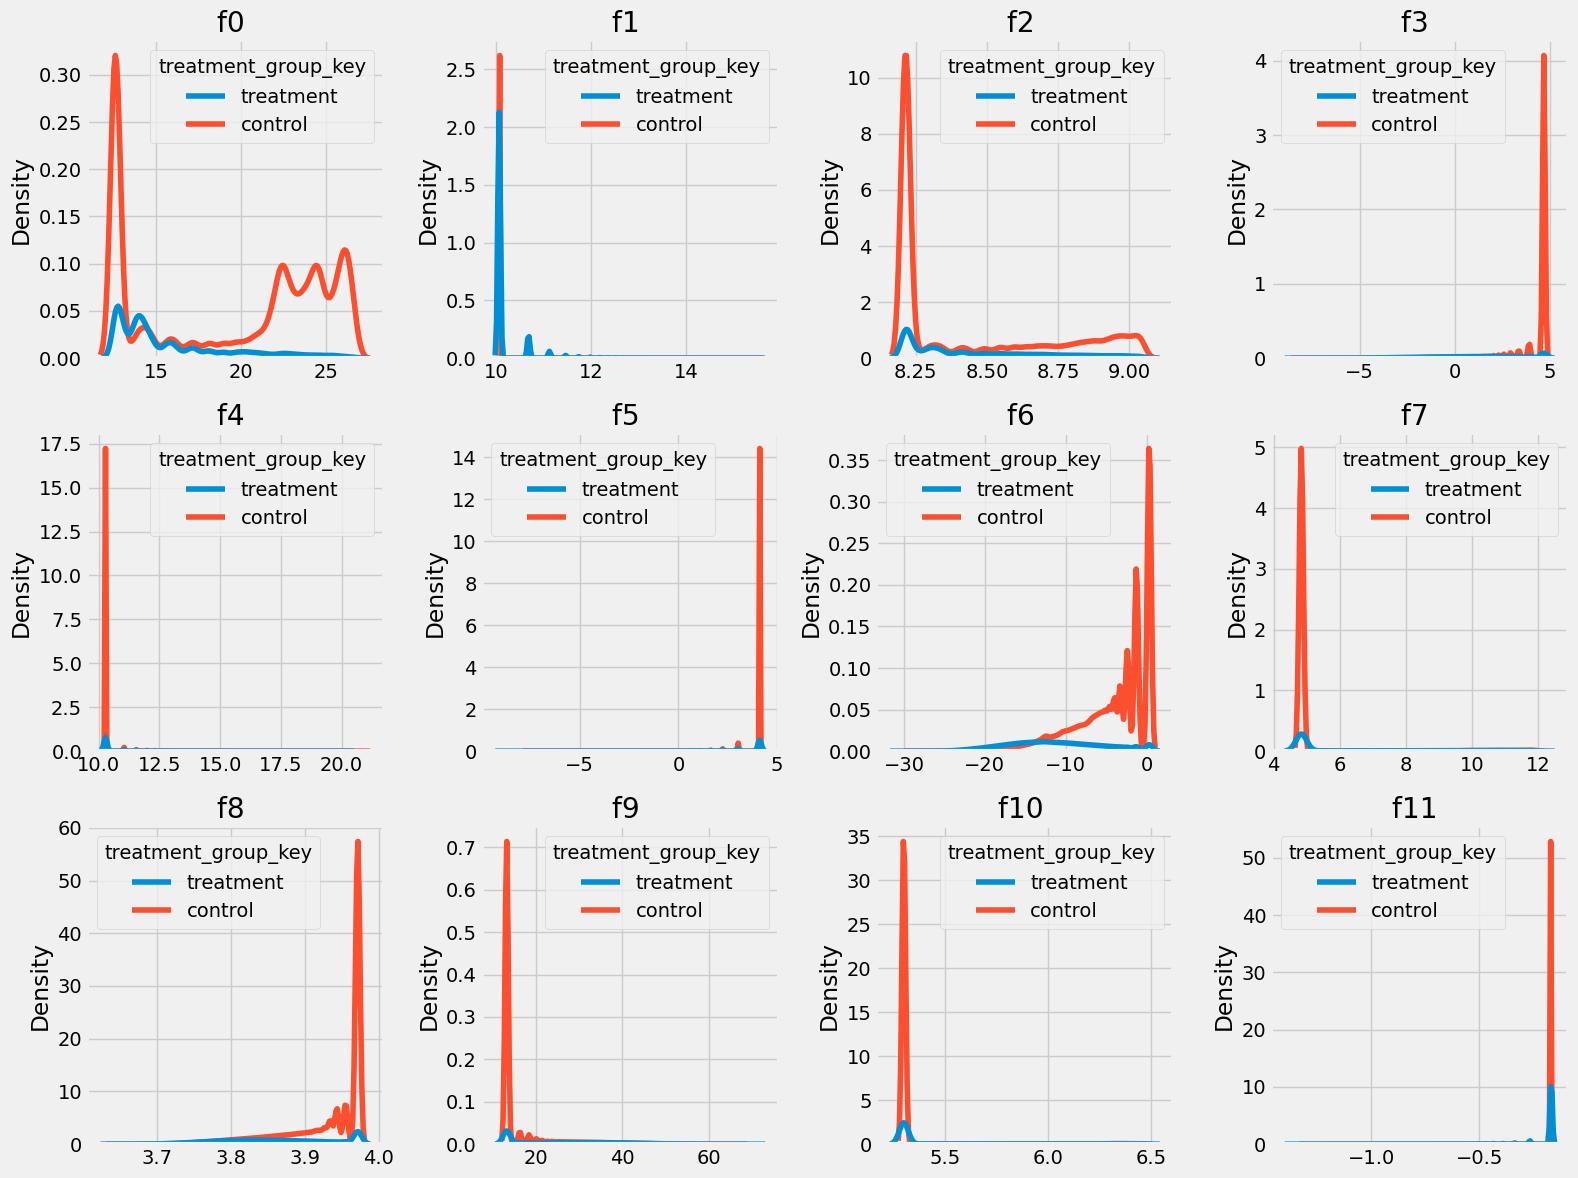

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12)) # Adjust figsize as needed for readability
axes = axes.flatten() # Flatten the 3x4 array of axes for easy iteration

feature_cols = [f'f{i}' for i in range(12) ]

for i, feature_col in enumerate(feature_cols):
    sns.kdeplot(data=df_sample, x=feature_col, hue= df_sample['treatment_group_key'], ax=axes[i])
    axes[i].set_title(f'{feature_col} ')
    axes[i].set_xlabel('') # Optional: remove individual x-labels if they clutter

plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

---
### 1. `exposure`가 `visit`에 미치는 인과 효과 추정 (S-leaner)

In [12]:
print("--- 1. Exposure가 Visit에 미치는 인과 효과 추정 ---")
# BaseSLearner 초기화
s_learner_visit = BaseSClassifier(
    learner= LGBMClassifier(verbose=-1)
)

features = [f'f{i}' for i in range(12)]

# 모델 학습
print("\n--- BaseSLearner 모델 학습 시작 (Visit) ---")
# .fit(X, T, Y)으로 학습합니다.
s_learner_visit.fit(X=df_sample[features] , treatment=  df_sample['exposure'], y= df_sample['visit'])

# 개별 처리 효과 (ITE) 예측
ite_visit_predictions_s_learner = s_learner_visit.predict(df_sample[features])

# 평균 처리 효과 (ATE) 계산
ate_visit_s_leaner = np.mean(ite_visit_predictions_s_learner)
print(f"\nExposure가 Visit에 미치는 ATE (Average Treatment Effect): {ate_visit_s_leaner:.6f}")

df_sample['s_learner_visit_pred'] = ite_visit_predictions_s_learner

--- 1. Exposure가 Visit에 미치는 인과 효과 추정 (CausalML - TransformedOutcome) ---

--- BaseSLearner 모델 학습 시작 (Visit) ---

Exposure가 Visit에 미치는 ATE (Average Treatment Effect): 0.208786


---
### 2. `exposure`가 `visit`에 미치는 인과 효과 추정 (Forest)

In [10]:
uplift_model_visit = UpliftRandomForestClassifier(
    control_name='control',
    # n_estimators=100,
    # max_depth= 3, # 너무 깊으면 과적합 및 시각화 어려움
    # min_samples_leaf=50, # 충분히 큰 리프 노드 크기
    # evaluationFunction='KL', # KL-Divergence를 사용하여 분할 (일반적 선택)
    n_jobs=-1,
    random_state=42
)


# 모델 학습
print("--- UpliftRandomForestClassifier 모델 학습 시작 (Visit) ---")

uplift_model_visit.fit(X= df_sample[features].values, treatment= df_sample['treatment_group_key'].values, y=df_sample['visit'].values)

# 개별 처리 효과 (ITE/CATE) 예측
ite_visit_predictions = uplift_model_visit.predict(df_sample[features])

# 평균 처리 효과 (ATE) 계산
ate_visit = np.mean(ite_visit_predictions)
print(f"\nExposure가 Visit에 미치는 ATE (Average Treatment Effect): {ate_visit:.6f}")

--- UpliftRandomForestClassifier 모델 학습 시작 (Visit) ---

Exposure가 Visit에 미치는 ATE (Average Treatment Effect): 0.383838


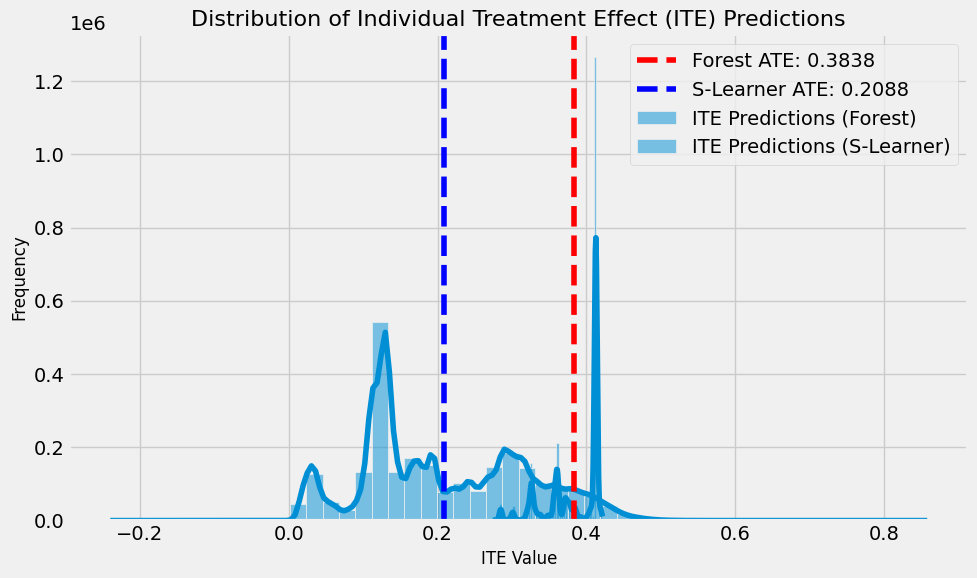

In [16]:
plt.figure(figsize=(10, 6))

# Plot histograms with transparency
sns.histplot(ite_visit_predictions, kde=True, bins=50, color='red', label='ITE Predictions (Forest)', alpha=0.5)
sns.histplot(ite_visit_predictions_s_learner, kde=True, bins=50, color='blue', label='ITE Predictions (S-Learner)', alpha=0.5)

# Plot ATE lines
plt.axvline(x=ate_visit, color='red', linestyle='--', label=f'Forest ATE: {ate_visit:.4f}')
plt.axvline(x=ate_visit_s_leaner, color='blue', linestyle='--', label=f'S-Learner ATE: {ate_visit_s_leaner:.4f}')

# Add title and labels
plt.title('Distribution of Individual Treatment Effect (ITE) Predictions', fontsize=16)
plt.xlabel('ITE Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add legend
plt.legend()
plt.tight_layout()
plt.show()

---
### 3. `exposure`가 `conversion`에 미치는 인과 효과 추정 (S-leaner)

In [17]:
print("--- 2. Exposure가 Conversion 에 미치는 인과 효과 추정 ---")
# BaseSLearner 초기화
s_learner_conversion = BaseSClassifier(
    learner= LGBMClassifier(verbose=-1)
)

# 모델 학습
print("\n--- BaseSLearner 모델 학습 시작 (Conversion) ---")
s_learner_conversion.fit(X=df_sample[features] , treatment=  df_sample['exposure'], y= df_sample['conversion'])

# 개별 처리 효과 (ITE) 예측
ite_conversion_predictions_s_learner = s_learner_conversion.predict(df_sample[features])

# 평균 처리 효과 (ATE) 계산
ate_conversion_s_learner = np.mean(ite_conversion_predictions_s_learner)
print(f"\nExposure가 Conversion 에 미치는 ATE (Average Treatment Effect): {ate_conversion_s_learner:.6f}")
df_sample['s_learner_conversion_pred'] = ite_conversion_predictions_s_learner

--- 2. Exposure가 Conversion 에 미치는 인과 효과 추정 ---

--- BaseSLearner 모델 학습 시작 (Conversion) ---

Exposure가 Conversion 에 미치는 ATE (Average Treatment Effect): 0.026620


---
### 4. `exposure`가 `conversion`에 미치는 인과 효과 추정 (Tree)

In [18]:
uplift_model_conversion = UpliftRandomForestClassifier(
    control_name='control',
    n_jobs=-1,
    random_state=42
)


# 모델 학습
print("--- UpliftRandomForestClassifier 모델 학습 시작 (conversion) ---")

uplift_model_conversion.fit(X= df_sample[features].values, treatment= df_sample['treatment_group_key'].values, y=df_sample['conversion'].values)

# 개별 처리 효과 (ITE/CATE) 예측
ite_conversion_predictions = uplift_model_conversion.predict(df_sample[features])

# 평균 처리 효과 (ATE) 계산
ate_conversion = np.mean(ite_conversion_predictions)
print(f"\nExposure가 Conversion 에 미치는 ATE (Average Treatment Effect): {ate_conversion:.6f}")

--- UpliftRandomForestClassifier 모델 학습 시작 (conversion) ---

Exposure가 Conversion 에 미치는 ATE (Average Treatment Effect): 0.057784


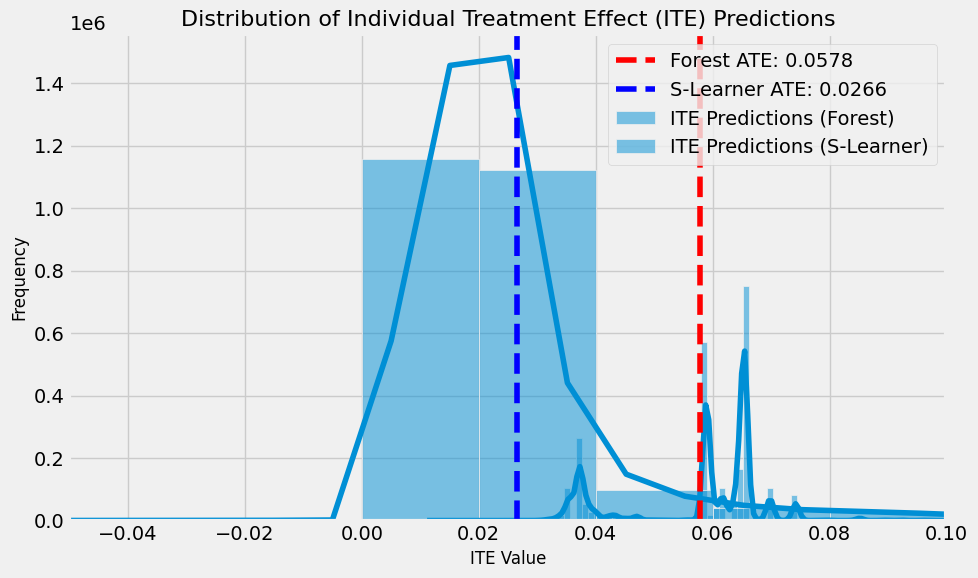

In [36]:
plt.figure(figsize=(10, 6))

# Plot histograms with transparency
sns.histplot(ite_conversion_predictions, kde=True, bins=100, color='red', label='ITE Predictions (Forest)', alpha=0.5)
sns.histplot(ite_conversion_predictions_s_learner, kde=True, bins=100, color='blue', label='ITE Predictions (S-Learner)', alpha=0.5)

# Plot ATE lines
plt.axvline(x=ate_conversion, color='red', linestyle='--', label=f'Forest ATE: {ate_conversion:.4f}')
plt.axvline(x=ate_conversion_s_learner, color='blue', linestyle='--', label=f'S-Learner ATE: {ate_conversion_s_learner:.4f}')

# Add title and labels
plt.title('Distribution of Individual Treatment Effect (ITE) Predictions', fontsize=16)
plt.xlabel('ITE Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(-0.05, 0.1)

# Add legend
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 0.1 단위로 구간(bin) 정의
bins = np.arange(0, 1.1, 0.1) # [0.0, 0.1, 0.2, ..., 1.0] 과 같은 구간을 생성합니다.

df_sample['pred_visit'] = ite_visit_predictions
df_sample['pred_conversion'] = ite_conversion_predictions
# 'pred' 컬럼을 0.1 단위 구간으로 나누어 'pred_interval' 컬럼 생성
df_sample['pred_interval'] = pd.cut(df_sample['pred_visit'], bins=bins, right=False, include_lowest=True, precision=1)

print("--- pred 구간별 전환율 및 개수 (Exposure 그룹별) ---")

# --- 컨트롤 그룹 (exposure = 0) 분석 ---
print("\n=== 컨트롤 그룹 (exposure = 0) ===")
df_control = df_sample[df_sample['exposure'] == 0].copy()
if not df_control.empty:
    # 'conversion'의 평균과 각 그룹의 개수(size)를 동시에 계산
    conversion_stats_control = df_control.groupby('pred_interval')['conversion'].agg(['mean', 'size']).reset_index()
    conversion_stats_control.rename(columns={'mean': '전환율', 'size': '개수'}, inplace=True)
    print(conversion_stats_control)
else:
    print("컨트롤 그룹 데이터가 없습니다.")

# --- 처리 그룹 (exposure = 1) 분석 ---
print("\n=== 처리 그룹 (exposure = 1) ===")
df_treatment = df_sample[df_sample['exposure'] == 1].copy()
if not df_treatment.empty:
    # 'conversion'의 평균과 각 그룹의 개수(size)를 동시에 계산
    conversion_stats_treatment = df_treatment.groupby('pred_interval')['conversion'].agg(['mean', 'size']).reset_index()
    conversion_stats_treatment.rename(columns={'mean': '전환율', 'size': '개수'}, inplace=True)
    print(conversion_stats_treatment)
else:
    print("처리 그룹 데이터가 없습니다.")

print("\n----------------------------------")

--- pred 구간별 전환율 및 개수 (Exposure 그룹별) ---

=== 컨트롤 그룹 (exposure = 0) ===
  pred_interval       전환율       개수
0    [0.0, 0.1)       NaN        0
1    [0.1, 0.2)       NaN        0
2    [0.2, 0.3)  0.001864    31116
3    [0.3, 0.4)  0.001972   849714
4    [0.4, 0.5)  0.001915  1216107
5    [0.5, 0.6)       NaN        0
6    [0.6, 0.7)       NaN        0
7    [0.7, 0.8)       NaN        0
8    [0.8, 0.9)       NaN        0
9    [0.9, 1.0)       NaN        0

=== 처리 그룹 (exposure = 1) ===
  pred_interval       전환율      개수
0    [0.0, 0.1)       NaN       0
1    [0.1, 0.2)       NaN       0
2    [0.2, 0.3)  0.016456   33848
3    [0.3, 0.4)  0.038224  220257
4    [0.4, 0.5)  0.080726  174107
5    [0.5, 0.6)       NaN       0
6    [0.6, 0.7)       NaN       0
7    [0.7, 0.8)       NaN       0
8    [0.8, 0.9)       NaN       0
9    [0.9, 1.0)       NaN       0

----------------------------------


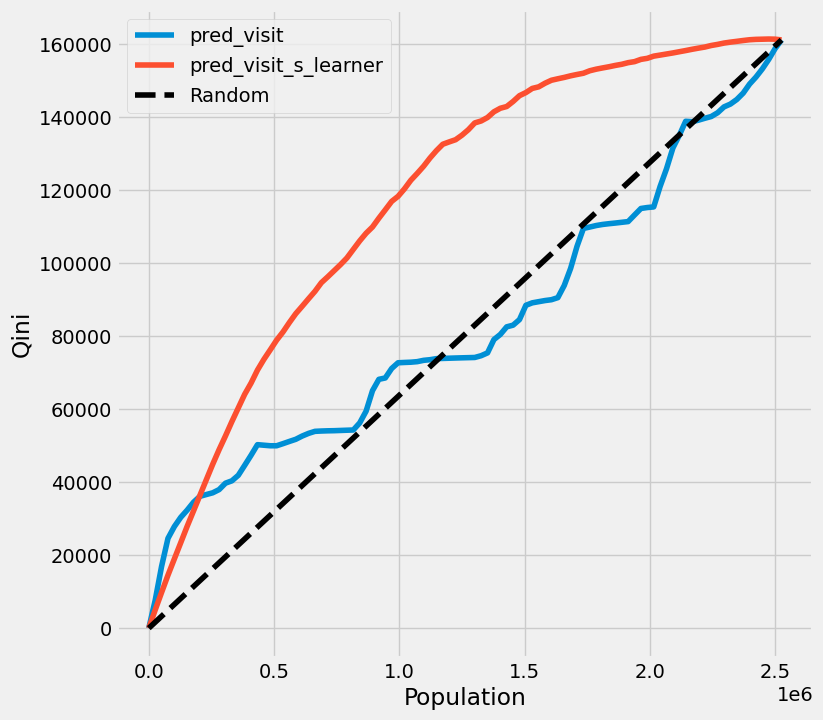

In [22]:
# -----------------------------------------------------------
# 3. Qini Curve 플로팅 및 Qini 값 계산
# -----------------------------------------------------------
from causalml.metrics import plot_qini

df_sample['pred_visit_s_learner'] = ite_visit_predictions_s_learner
df_sample['pred_visit'] = ite_visit_predictions

df_sample['pred_conversion_s_learner'] = ite_conversion_predictions_s_learner
df_sample['pred_conversion'] = ite_conversion_predictions

plot_qini(df_sample[['visit', 'exposure', 'pred_visit', 'pred_visit_s_learner']], outcome_col='visit', treatment_col='exposure')

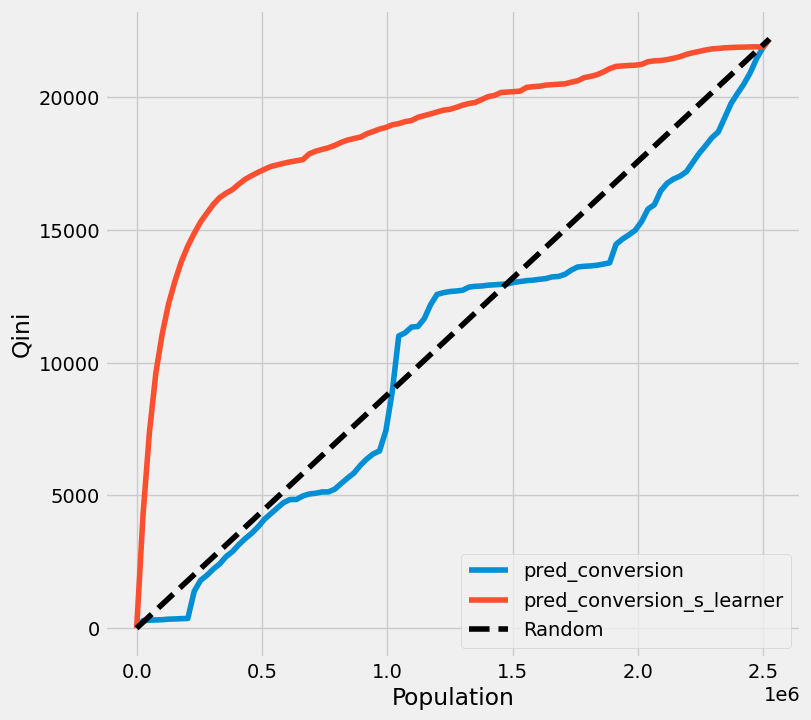

In [24]:
plot_qini(df_sample[['conversion', 'exposure', 'pred_conversion', 'pred_conversion_s_learner']], outcome_col='conversion', treatment_col='exposure')

In [26]:
from sklift.metrics import uplift_auc_score

In [30]:
# qini_score 함수를 사용하여 Qini 값 (AULC) 계산
auuc_value = uplift_auc_score(y_true= df_sample['visit'], uplift= df_sample['pred_visit_s_learner'], treatment= df_sample['exposure'])
print(f"S-Learner AUUC (visit): {auuc_value:.4f}")
auuc_value = uplift_auc_score(y_true= df_sample['visit'], uplift= df_sample['pred_visit'], treatment= df_sample['exposure'])
print(f"Forest AUUC (visit) : {auuc_value:.4f}")

print('')

auuc_value = uplift_auc_score(y_true= df_sample['conversion'], uplift= df_sample['pred_conversion_s_learner'], treatment= df_sample['exposure'])
print(f"S-Learner AUUC (conversion): {auuc_value:.4f}")

auuc_value = uplift_auc_score(y_true= df_sample['conversion'], uplift= df_sample['pred_conversion'], treatment= df_sample['exposure'])
print(f"Forest AUUC (conversion): {auuc_value:.4f}")

S-Learner AUUC (visit): 0.1741
Forest AUUC (visit) : 0.1317

S-Learner AUUC (conversion): 0.0491
Forest AUUC (conversion): 0.0185


# 정리
- 1,400만 데이터 셋 중, 18% 만 사용 (15%는 통제군, 3%는 처리군)
- visit와 conversion을 결과 변수로 두고 분석 진행
    - 단, Forest의 성능 비교를 위해 S-Learner 비교

## visit 예측 결과 확인
- S-learner는 예측값 분포가 넓고 Forest는 비교적 좁은 모습
- Qini 곡선을 확인하면 S-leaner가 훨씬 잘 예측했다는 것을 확인할 수 있음
- AUUC값도 마찬가지 S-learner = 0.1741, Forest = 0.1317

## conversion 예측 결과 확인
- 이번엔 반대로 S-learner는 예측값 분포가 좁고 Forest는 넓은 모습
- Qini 곡선을 확인하면 S-leaner가 훨씬 잘 예측했다는 것을 확인할 수 있음
- AUUC값도 마찬가지 S-learner = 0.0491, Forest = 0.0185

## Uplift 결과 확인 (상위 10%, 하위 10% 차이)
- visit 결과를 기준으로 f0, f3, f6, f7, f9 변수만 사용해도 좋은 모델링이 가능할 것 같음 (Tree 모델 기준)
- 나머지 변수들은 큰 변동이 없음.

In [50]:
# 0.1 단위로 구간(bin) 정의
bins = np.arange(0, 1.1, 0.1)
df_sample['pred_interval'] = pd.cut(df_sample['pred_visit_s_learner'], bins=bins, right=False, include_lowest=True, precision=1)

# 'pred_interval' 별로 각 feature의 평균 계산
feature_means_by_interval = df_sample.groupby('pred_interval')[features].mean()

print("--- pred_visit_s_learner 구간별 feature 평균 ---")
feature_means_by_interval
print("0, 3, 6, 7, 9 정도 변수가 의미 있는 것 같음")

--- pred_visit_s_learner 구간별 feature 평균 ---


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
pred_interval,,,,,,,,,,,,
"[0.0, 0.1)",16.743387,10.085365,8.244769,2.620536,10.284242,3.925899,-7.250785,5.408562,3.970298,13.202582,5.302603,-0.168797
"[0.1, 0.2)",23.105812,10.073186,8.312001,4.235699,10.337403,4.010851,-5.291295,5.138248,3.959336,13.890898,5.312163,-0.172520
"[0.2, 0.3)",15.705184,10.101696,8.772274,3.773944,10.469672,3.904350,-3.860087,5.251446,3.901824,18.185835,5.372857,-0.177928
"[0.3, 0.4)",15.147044,10.099346,8.532445,3.547086,10.457815,3.881126,-4.483159,5.347360,3.867018,23.169164,5.407937,-0.175155
"[0.4, 0.5)",17.441361,10.103782,8.437898,2.760926,10.453980,3.808081,-8.137773,5.595855,3.818382,29.288816,5.431078,-0.172769
"[0.5, 0.6)",22.426093,10.060206,8.639807,3.542086,10.593701,3.948772,-9.418490,5.576108,3.770984,31.861876,5.507725,-0.174140
"[0.6, 0.7)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"[0.7, 0.8)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"[0.8, 0.9)",26.160134,10.059654,8.214383,4.679882,10.280525,1.798004,-11.858909,11.710898,3.971858,13.190056,5.300375,-0.168679


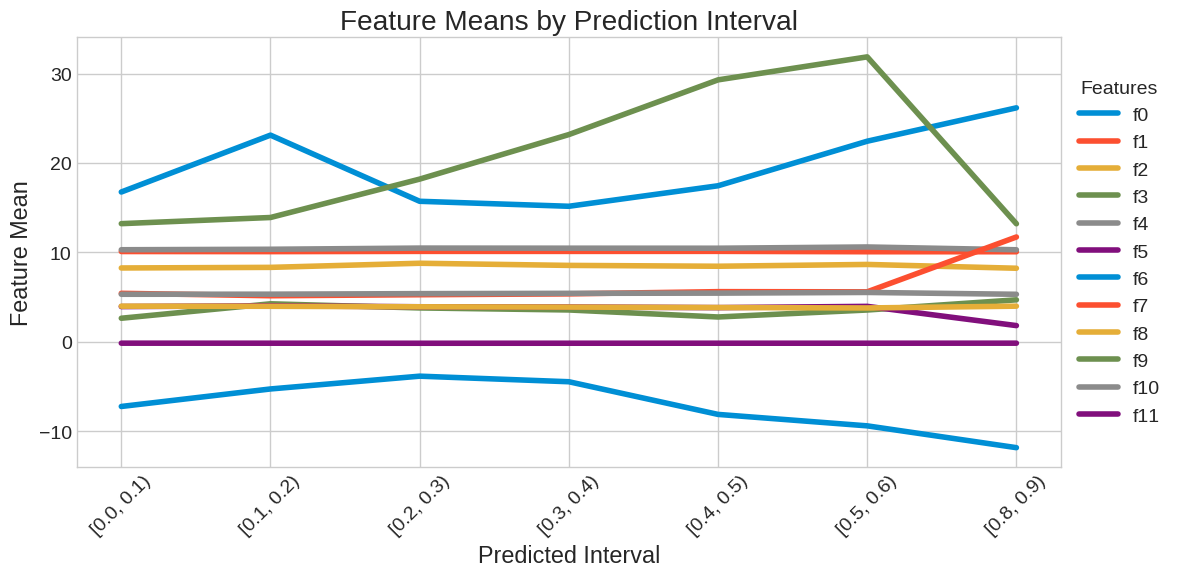

In [63]:
# 특정 인덱스(6,7,9) 제외
drop_idx = [6, 7, 9]
feature_means_filtered = feature_means_by_interval.drop(feature_means_by_interval.index[drop_idx])
interval_labels_filtered = feature_means_filtered.index.astype(str)

# 라인 플롯 그리기
plt.figure(figsize=(12, 6))

for col in feature_means_filtered.columns:
    plt.plot(interval_labels_filtered, feature_means_filtered[col], label=col)

plt.xlabel('Predicted Interval')
plt.ylabel('Feature Mean')
plt.title('Feature Means by Prediction Interval')
plt.xticks(rotation=45)
plt.legend(title="Features", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()